Importing the libraies

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import re
import time
from google.colab.patches import cv2_imshow

 Function to display images


In [7]:
def image_read(image1, image2, title1 = "", title2 = ""):
    fig = plt.figure(figsize = (15, 15))
    ax1 = fig.add_subplot(121)
    ax1.imshow(image1, cmap = "gray")
    ax1.set(xticks = [], yticks = [], title = title1)
    ax2 = fig.add_subplot(122)
    ax2.imshow(image2, cmap = "gray")
    ax2.set(xticks = [], yticks = [], title = title2)

Loading image


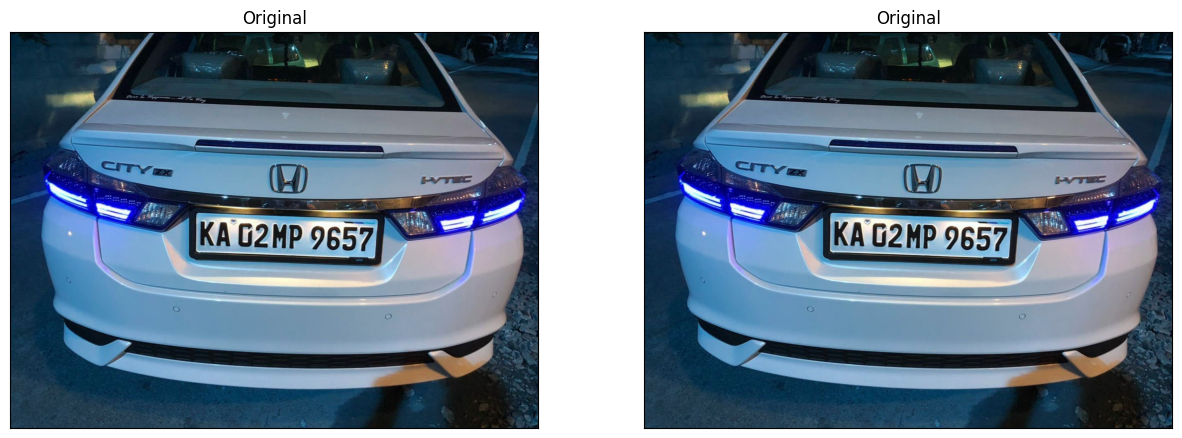

In [8]:
path = "/content/car1.PNG"
if os.path.exists(path):
    image = cv2.imread(path)
    if image is not None:
        image_read(image, image, title1 = "Original", title2 = "Original")
        plt.show()  # Display the plot
    else:
        print("Error: Failed to load image. Please check the path.")
else:
    print("Error: The specified file does not exist.")



Mount Google Drive

In [9]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Doing Image Operations

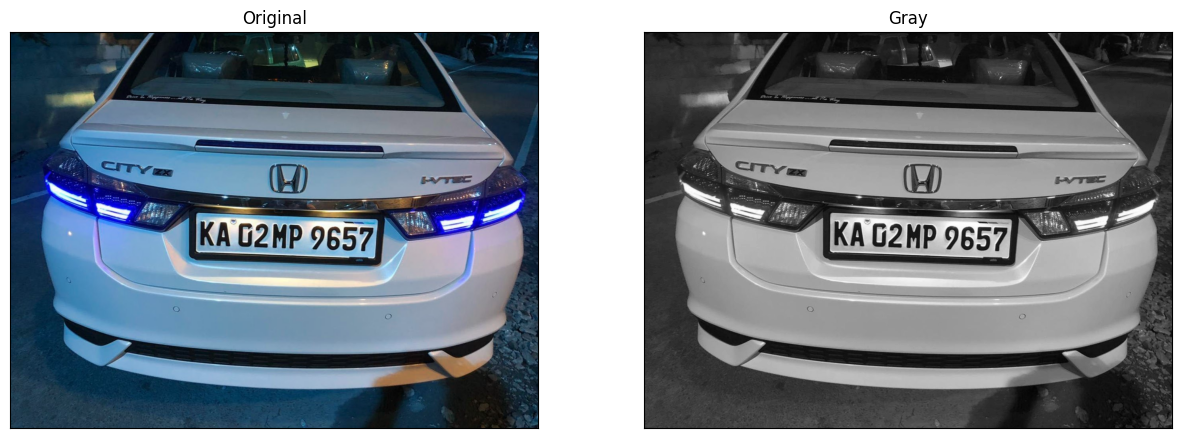

In [11]:
# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_read(image, gray, title1 = "Original", title2 = "Gray")

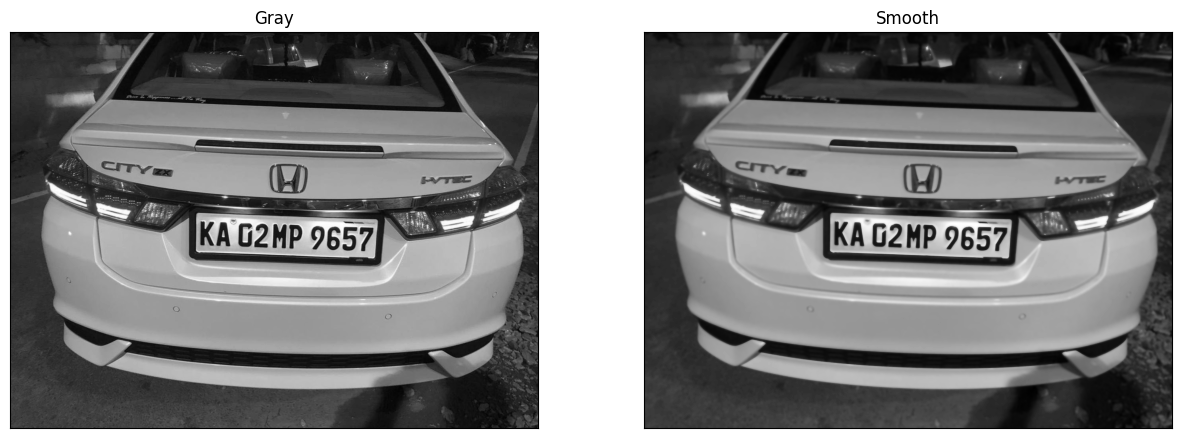

In [12]:
# Apply bilateral filter
smooth = cv2.bilateralFilter(gray, 9, 75, 75)
image_read(gray, smooth, title1 = "Gray", title2 = "Smooth")

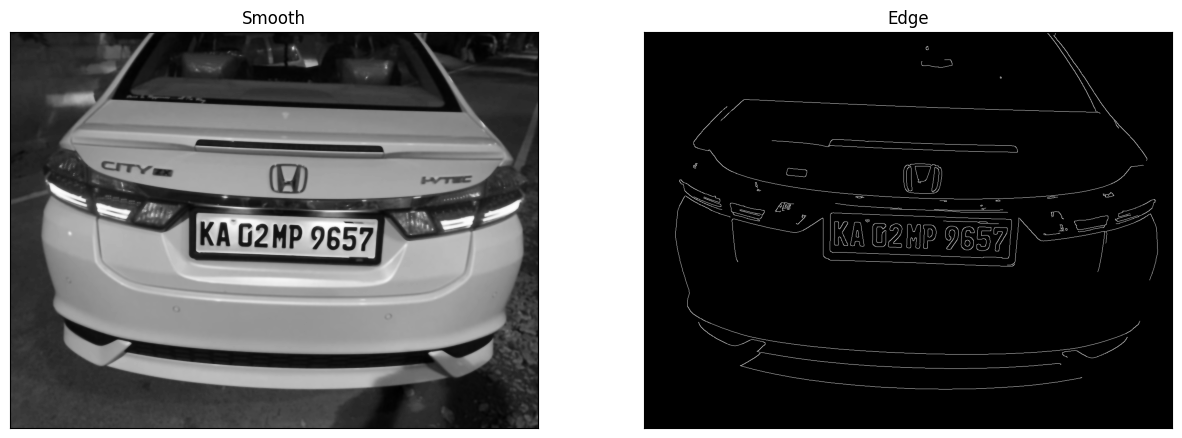

In [13]:
# Edge detection
edge = cv2.Canny(smooth, 70, 400)
image_read(smooth, edge, title1 = "Smooth", title2 = "Edge")

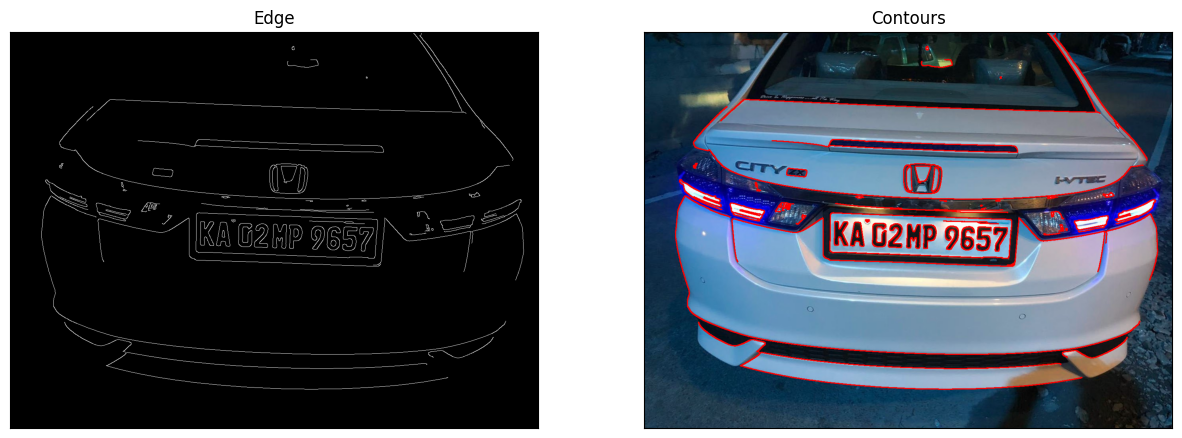

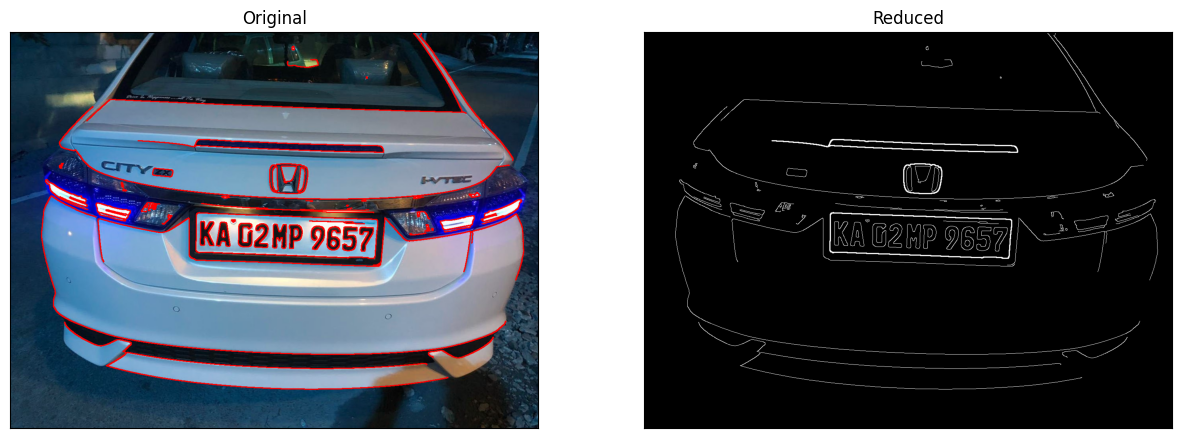

In [14]:


# Find and draw contours
contours, _ = cv2.findContours(edge.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
image_copy = image.copy()
cv2.drawContours(image_copy, contours, -1, (255, 0, 0), 2)
image_read(edge, image_copy, title1 = "Edge", title2 = "Contours")

# Filter contours
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
image_reduced = edge.copy()
cv2.drawContours(image_reduced, contours, -1, (255, 0, 0), 2)
image_read(image_copy, image_reduced, title1 = "Original", title2 = "Reduced")



# Detect number plate

Plate detected!
Plate saved successfully!


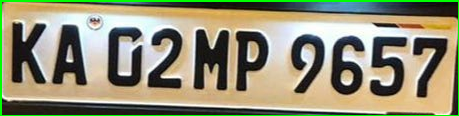

In [15]:
plate = None
for contour in contours:
    a = cv2.arcLength(contour, True)
    edge_count = cv2.approxPolyDP(contour, 0.02 * a, True)
    if 4 <= len(edge_count) <= 6:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        if 2 <= aspect_ratio <= 6:  # typical license plate aspect ratio
            plate = image[y:y+h, x:x+w]
            print("Plate detected!")
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            break
else:
    print("No plate detected!")

if plate is not None:
    cv2.imwrite("plate.jpg", plate)
    print("Plate saved successfully!")
    cv2_imshow(plate)
else:
    print("No plate found to save.")




Extracted alphanumeric characters: KA G2MP 9657

Accuracy Percentage: 90.0


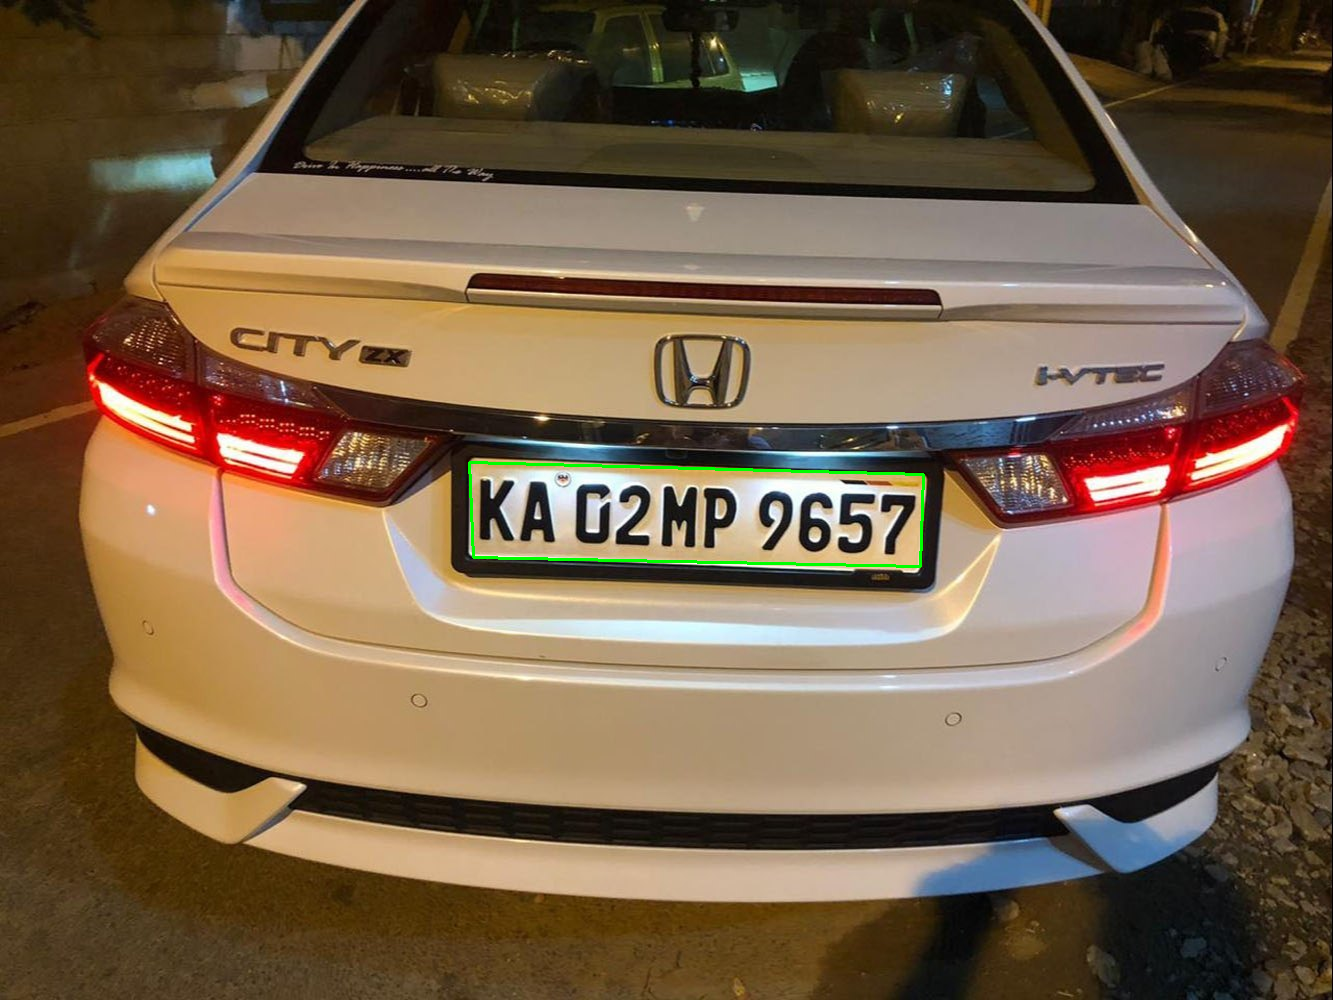

Total Time: 0.9836888313293457


In [43]:
import cv2
import pytesseract
import time
from google.colab.patches import cv2_imshow
import re

# Set the path to the Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

# Define a function to preprocess text
def preprocess_text(text):
    # Convert to lowercase and remove whitespace and special characters
    return re.sub(r'\W+', '', text.lower())

# Define the detect_number_plate function
def detect_number_plate(image_path, ground_truth):
    start_time = time.time()  # Start time of the function

    # Read the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Perform edge detection using Canny
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area and find the largest contour
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    number_plate = None

    # Iterate through the contours
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

        # If the contour has 4 vertices (likely a rectangle)
        if len(approx) == 4:
            number_plate = approx
            break

    # If a number plate is found, draw a bounding box around it
    if number_plate is not None:
        cv2.drawContours(image, [number_plate], -1, (0, 255, 0), 2)

        # Extract the region of interest (number plate)
        x, y, w, h = cv2.boundingRect(number_plate)
        roi = gray[y:y + h, x:x + w]

        # Perform OCR on the number plate region
        alphanumeric_text = pytesseract.image_to_string(roi, config='--psm 6')  # PSM 6 assumes a single uniform block of text
        print("Extracted alphanumeric characters:", alphanumeric_text)

        # Preprocess ground truth and extracted text
        ground_truth = preprocess_text(ground_truth)
        alphanumeric_text = preprocess_text(alphanumeric_text)

        # Calculate accuracy percentage
        num_correct = sum(1 for a, b in zip(alphanumeric_text, ground_truth) if a == b)
        accuracy_percentage = (num_correct / len(ground_truth)) * 100
        print("Accuracy Percentage:", accuracy_percentage)

    # Display the image with the detected number plate
    cv2_imshow(image)

    end_time = time.time()  # End time of the function
    total_time = end_time - start_time
    print("Total Time:", total_time)

# Call the function with the image file path and ground truth alphanumeric characters
image_path = "car1.PNG"  # Provide the correct path to your image
ground_truth = "KA 02MP 9657"  # Replace with the ground truth alphanumeric characters
detect_number_plate(image_path, ground_truth)
